# Count models

Counting is easy, right? Not so fast, bub...

Plan: talk about counting

* car crashes (TDOT data)
* births (U.S. Census data, via Wonder)
* coughs (proprietary Hyfe data)


## Imports and settings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st

In [2]:
sns.set_theme()
plt.rcParams['figure.figsize'] = [12,8]

## Monthly car crashes in Tennessee

In [3]:
crashes = pd.read_csv("TDOT.csv")
crashes

,County,Year,January,February,March,April,May,June,July,August,September,October,November,December
0,Anderson,2010,138,113,169,169,155,152,165,176,178,169,179,152
1,Bedford,2010,71,72,77,70,87,99,90,91,86,118,105,95
2,Benton,2010,21,23,27,32,34,29,16,43,31,50,29,36
3,Bledsoe,2010,5,1,3,3,5,1,7,4,3,6,4,3
4,Blount,2010,126,159,171,145,153,139,201,264,338,267,316,269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040,Wayne,2020,23,15,19,27,18,22,20,24,23,18,22,19
1041,Weakley,2020,39,35,40,19,28,43,37,47,54,44,33,21
1042,White,2020,30,31,33,21,50,32,36,46,34,29,42,43
1043,Williamson,2020,394,424,270,170,226,304,312,310,293,405,368,377


### Meigs county and the Poisson distribution

In [4]:
meigs = crashes[crashes["County"]=="Meigs"]
meigs = meigs.drop("County",1)
meigs

,Year,January,February,March,April,May,June,July,August,September,October,November,December
60,2010,11,8,10,14,18,12,17,15,16,11,18,14
155,2011,13,14,15,8,13,14,8,14,13,13,14,8
250,2012,12,5,14,11,14,12,16,15,16,15,12,11
345,2013,10,11,15,19,17,6,10,14,19,35,22,12
440,2014,16,16,17,11,16,8,9,13,13,11,17,8
535,2015,10,16,16,14,20,18,16,14,14,19,17,17
630,2016,18,15,17,18,14,14,21,16,9,10,13,16
725,2017,13,12,15,15,12,10,14,9,16,17,19,18
820,2018,14,18,13,10,13,16,12,11,11,12,12,9
915,2019,12,9,6,9,14,20,10,14,9,13,15,11


In [5]:
meigs = meigs.melt( id_vars="Year", var_name="Month", value_name="Crashes" )
meigs

,Year,Month,Crashes
0,2010,January,11
1,2011,January,13
2,2012,January,12
3,2013,January,10
4,2014,January,16
...,...,...,...
127,2016,December,16
128,2017,December,18
129,2018,December,9
130,2019,December,11


In [6]:
meigs.agg( Mean = ("Crashes","mean"), Variance = ("Crashes","var") )

,Crashes
Mean,13.712121
Variance,15.198936


<AxesSubplot:xlabel='Sample', ylabel='Count'>

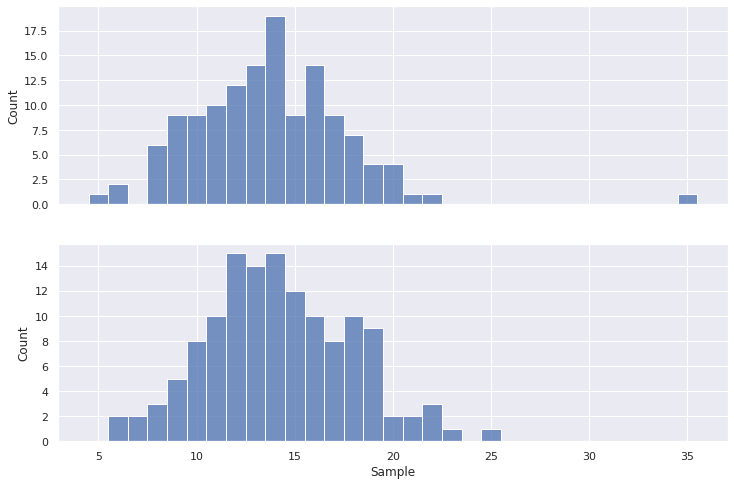

In [29]:
fig, axs = plt.subplots(2, sharex=True)
sns.histplot( data=meigs, x="Crashes", discrete=True, ax=axs[0])
# plt.title("Monthly car crashes in Meigs County, TN (2010-2020)")
r = pd.DataFrame({"Sample" : st.poisson.rvs( np.mean(meigs["Crashes"]), size=meigs.shape[0])})
sns.histplot(data=r, x="Sample", discrete=True, ax=axs[1])

### The Poisson distribution

The number of crashes per month is a **_count variable_**, a random variable (RV) whose only possible values are nonnegative integers. The histograms show even more: this is a **_Poisson RV_** with mean $\mu = 13.7$ and variance $\sigma^2 = 15.2 \approx \mu$.

In general, a Poisson RV with parameter $\mu$ satisfies
$$P(X=k) ~ = ~ e^{-\mu} \, \frac{ \mu^{k} }{ k! } \ , \quad \text{for} \quad k = 0, 1, 2, \ldots \ ,$$
with mean and variance _both_ equal to $\mu$. 

### Predicting future events

When you have a Poisson count variable with a known mean, it's easy to predict the probabilities of various outcomes -- just use the probability distribution above. Here's the probability model for monthly crashes in Meigs county:

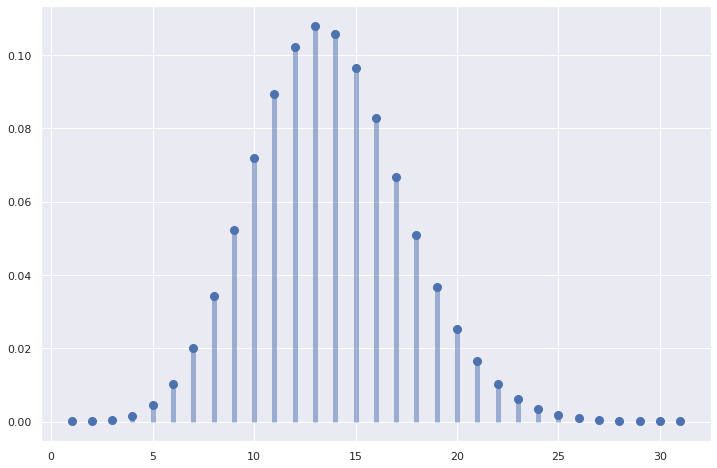

In [39]:
mu = np.mean( meigs["Crashes"] )
x = np.arange(st.poisson.ppf(0.00001, mu), st.poisson.ppf(0.99999, mu))
plt.plot(x, st.poisson.pmf(x, mu), 'bo', ms=8, label='poisson pmf')
plt.vlines(x, 0, st.poisson.pmf(x, mu), colors='b', lw=5, alpha=0.5)

According to this model, which fits the empirical observations well, it's pretty likely to have 10-17 crashes in a month, but it's unlikely to have fewer than 5 or more than 25 in a given month. This is information that county officials can use!

While monthly traffic accidents are roughly Poisson in some counties, but they're definitely not in others...

### Knox county and overdispersion

In [10]:
knox = crashes[crashes["County"]=="Knox"]
knox = knox.drop("County",1)
knox

,Year,January,February,March,April,May,June,July,August,September,October,November,December
46,2010,894,858,1027,1110,1058,974,906,1005,1177,1156,1149,940
141,2011,804,805,1059,1026,993,1069,1028,1104,1070,1188,1214,1136
236,2012,984,1048,1161,1116,1087,933,978,1068,1034,1169,1114,1027
331,2013,1001,822,1042,1075,1100,968,977,1115,971,1105,1159,1057
426,2014,928,846,939,1083,1041,891,982,1061,1055,1241,1085,1140
521,2015,992,797,1055,1146,1103,977,1083,1185,1230,1355,1195,1261
616,2016,981,1015,1154,1176,1137,1111,1175,1291,1276,1269,1283,1281
711,2017,984,1030,1200,1273,1195,1188,1067,1261,1243,1323,1301,1279
806,2018,1052,1077,1177,1257,1233,1162,1092,1277,1176,1273,1437,1356
901,2019,1104,1079,1252,1294,1177,1087,1092,1221,1240,1428,1303,1250


In [11]:
knox = knox.melt( id_vars="Year", var_name="Month", value_name="Crashes" )
knox.agg( Mean = ("Crashes","mean"), Variance = ("Crashes","var") )

,Crashes
Mean,1095.613636
Variance,22377.185461


<AxesSubplot:xlabel='Sample', ylabel='Count'>

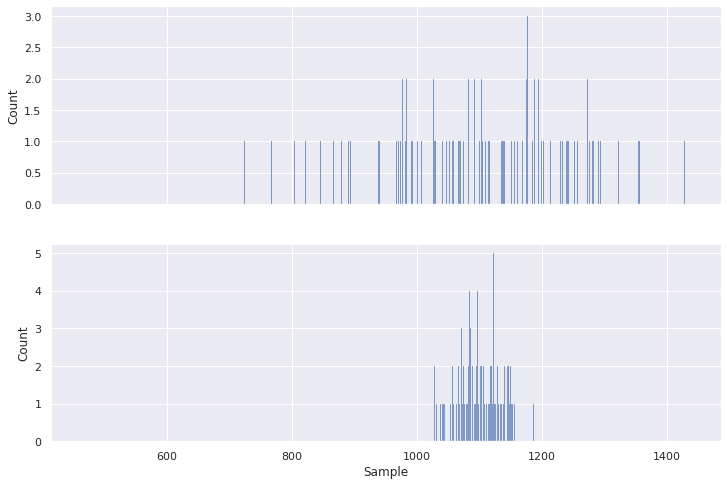

In [28]:
fig, axs = plt.subplots(2, sharex=True)
sns.histplot( data=knox, x="Crashes", discrete=True, ax=axs[0])
r = pd.DataFrame({"Sample" : st.poisson.rvs(np.mean(knox["Crashes"]),size=meigs.shape[0])})
sns.histplot(data=r, x="Sample", discrete=True, ax=axs[1])

The monthly crashes in Knox county do **_NOT_** follow a Poisson distribution!!

What's going on here? This is **_overdispersion_**: the variance, 22377.2, is much larger than the mean, 1095.6, so this RV can't be Poisson.

## Monthly births in the U.S.

### Overdispersion and the negative binomial distribution

## Coughs per hour